In [1]:
import os, cv2, dlib, re, pyrender, trimesh
import numpy as np
import scipy.io as sio
import os.path as osp
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 

In [32]:
def loadObj(file):
    obj = {}
    obj['v'],obj['vn'],obj['vt'],obj['f'] = [],[],[],[]
    f = open(file, "r")
    lines = f.readlines()
    delimiters = " ", "//", "\\","/","\\"
    regexPattern = '|'.join(map(re.escape, delimiters))
    for item in lines:
        data = re.split(regexPattern, item)
        if 'v' == data[0]:
            obj['v'].append(np.array(data[1:]).astype('float'))
        elif 'vt' == data[0]:
            obj['vt'].append(np.array(data[1:]).astype('float'))
        elif 'vn' == data[0]:
            obj['vn'].append(np.array(data[1:]).astype('float'))
        elif 'f' == data[0]:
            obj['f'].append(np.array(data[1:]).astype('int32'))
    
    hasVN,hasVT = False,False
    if len(obj['v']):
        obj['v'] = np.vstack(obj['v'])
    if len(obj['vn']):
        hasVN = True
        obj['vn'] = np.vstack(obj['vn'])
    if len(obj['vt']):
        hasVT = True
        obj['vt'] = np.vstack(obj['vt'])
    if len(obj['f']):
        obj['f'] = np.vstack(obj['f'])
    
    f = np.ones((9,obj['f'].shape[0]))
    if  hasVN and hasVT:
        f = obj['f'][:,[0,3,6,2,5,8,1,4,7]].T
    elif hasVN and obj['f'].shape[1]==6:
        f[:6] = obj['f'][:,[0,2,4,1,3,5]].T
    elif hasVT and obj['f'].shape[1]==6:
        f[[0,1,2,6,7,8]] = obj['f'][:,[0,2,4,1,3,5]].T
    else:
        f[[0,1,2]] = obj['f'].T
    obj['f'] = f.astype('uint32')-1
    return obj

def saveObj(file,obj):
    f = open(file, "w")
    for item in obj['v']:
        print('v %.4f %.4f %.4f'%tuple(item),file=f)
    if len(obj['vn']):
        for item in obj['vn']:
            print('vn %.4f %.4f %.4f'%tuple(item),file=f)
    if len(obj['vt']):
        for item in obj['vt']:
            print('vt %.4f %.4f'%tuple(item),file=f)
       
    for item in obj['f'].T+1:
        if len(obj['vn']) and len(obj['vt']):
            print('f %d/%d/%d %d/%d/%d %d/%d/%d'%tuple(item[[0,3,6,2,5,8,1,4,7]]),file=f)
        elif len(obj['vn']) :
            print('f %d/%d %d/%d %d/%d'%tuple(item[[0,3,1,4,2,5]]),file=f)
        elif len(obj['vt']):
            print('f %d/%d %d/%d %d/%d'%tuple(item[[0,6,1,7,2,8]]),file=f)
        else:
            print('f %d %d %d'%tuple(item[:3]),file=f)
    f.close()

def rect_to_bb_padding(rect,h,w,x_para = 1.0 / 2,y_para = 1.0 / 2):
    x_len = rect.right() - rect.left()
    y_len = rect.bottom() - rect.top()
    left = max(  int(rect.left() - x_para * x_len), 0)
    right = min(  int(rect.right() + x_para * x_len-1), w - 1)
    top = max( int(rect.top() - 1.4*y_para * y_len) ,0)
    bottom = min( int(rect.bottom() + 0.6*y_para * y_len-1), h - 1)
    return np.array([left, top, right-left, bottom-top])

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return np.array([x, y, w, h])

def landmark_detect(gray):
    rects = detector(gray, 1)
    if len(rects)==0:
        return None,None
   
    h,w = gray.shape[:2]
    bbox = rect_to_bb_padding(rects[0],h,w)
    gray = gray[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    rects = detector(gray, 1)
    if len(rects)==0:
        return None,None
    
    rect = rects[0]
    shape = predictor(gray, rect)
    lm = np.array([[p.x+bbox[0], p.y+bbox[1]] for p in shape.parts()])

    return lm, bbox

def angle2matrix(pose):
    ''' compute Rotation Matrix from three Euler angles
    '''
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(pose[0]), -np.sin(pose[0])],
                    [0, np.sin(pose[0]), np.cos(pose[0])]
                    ])

    R_y = np.array([[np.cos(pose[1]), 0, np.sin(pose[1])],
                    [0, 1, 0],
                    [-np.sin(pose[1]), 0, np.cos(pose[1])]
                    ])

    R_z = np.array([[np.cos(pose[2]), -np.sin(pose[2]), 0],
                    [np.sin(pose[2]), np.cos(pose[2]), 0],
                    [0, 0, 1]
                    ])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def matrix2angle(R):
    #assert (isRotationMatrix(R))

    sy = np.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

    singular = sy < 1e-6

    if not singular:
        x = np.arctan2(R[2, 1], R[2, 2])
        y = np.arctan2(-R[2, 0], sy)
        z = np.arctan2(R[1, 0], R[0, 0])
    else:
        x = np.arctan2(-R[1, 2], R[1, 1])
        y = np.arctan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])


def save_to_pts(lm,file):
    f = open(file,'w')
    print('version: 1\nn_points:  68\n{',file=f)
    for i in range(68):
        print('%d %d'%(lm[i,0],lm[i,1]),file=f)
    print('}',file=f)
    f.close()
    
def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)

    for i in range(0, 68):
        coords[i] = (np.round(shape.part(i).x), np.round(shape.part(i).y))

    return coords

def load_imgs(path,size=512):
    imgs,pts = [],[]
    if os.path.isdir(path):
        files = os.listdir(path)
    else:
        files = [path]
    for item in files:
        file = os.path.join(path,item)
        img = cv2.imread(file)
        downScele = np.min(img.shape[:2])/512
        downShape = np.round(img.shape[:2]/downScele).astype('int')
        gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(downShape[1],downShape[0]))
        lm,_ = landmark_detect(gray)
        if lm is None:
            continue

        downScale = img.shape[:2]/downShape
        pts.append(lm*downScale)
        imgs.append(img)
    pts,imgs = np.stack(pts,axis=0),np.stack(imgs,axis=0)
    return imgs, pts

def rescale_bbox(newShape,oldShape,bbox,lm):
    downScale = newShape/oldShape
    lm = lm*downScale[[1,0]]
    bbox[[0,2]] = (bbox[[0,2]]*downScale[1]).astype('int')
    bbox[[1,3]] = (bbox[[1,3]]*downScale[0]).astype('int')
    return bbox,lm
    
def load_imgs_and_centercrop(path,size=512):
    imgs,pts = [],[]
    if os.path.isdir(path):
        files = os.listdir(path)
    else:
        files = [path]
    for item in files:
        file = os.path.join(path,item)
        img = cv2.imread(file)
        downScele = np.min(img.shape[:2])/512
        downShape = np.round(img.shape[:2]/downScele).astype('int')
        gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),(downShape[1],downShape[0]))
        lm, bbox = landmark_detect(gray)
        if lm is None:
            continue
        
        bbox,lm = rescale_bbox(img.shape[:2], downShape,bbox,lm)

        # shift to [0,0]
        img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        lm -= bbox[:2].reshape((1,2))
        
        img = cv2.resize(img,(size,size))
        bbox,lm = rescale_bbox(np.array([size,size]),bbox[[3,2]],bbox,lm)
        
        pts.append(lm)
        imgs.append(img)
    pts,imgs = np.stack(pts,axis=0),np.stack(imgs,axis=0)
    return imgs, pts

def ortho(frustum):
    left,right,bottom,top = frustum[:]
    projection = np.eye(4)
    projection[0,0], projection[1,1],projection[2,2] = 2/(right - left), 2/(top - bottom), -1
    projection[0,3],projection[1,3] = -(right + left) / (right - left),  -(top + bottom) / (top - bottom)
    return projection

def render(mesh,fy,cam=np.eye(4),model=np.eye(4),resolution=[512,512]):

    obj = pyrender.Mesh.from_trimesh(mesh, smooth=True)
    fovY = 2*np.arctan(resolution[0]/2/fy)
    # compose scene
    scene = pyrender.Scene(ambient_light=[0.1, 0.1, 0.1], bg_color=[0, 0, 0])
    camera = pyrender.PerspectiveCamera( yfov=fovY)
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=8)

    scene.add(obj, pose=  model)
    scene.add(light, pose=  model)
    scene.add(camera, pose = cam)
    
    # render scene
    r = pyrender.OffscreenRenderer(resolution[1], resolution[0])
    color, depth = r.render(scene)
    color,depth = color[::-1,::-1],depth[::-1,::-1]
    return color,depth

def render2(mesh,cam=np.eye(4),model=np.eye(4),scale=[1,1],resolution=[720,1280]):

    obj = pyrender.Mesh.from_trimesh(mesh, smooth=True)

    scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[0, 0, 0])
    camera = pyrender.OrthographicCamera(xmag=1, ymag=resolution[0]/2/scale[1], znear=1e-3, zfar=10000.0)
    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)

    scene.add(obj, pose=  model)
    scene.add(light, pose=  model)
    scene.add(camera, pose = cam)
    
    # render scene
    r = pyrender.OffscreenRenderer(resolution[1], resolution[0])
    color, _ = r.render(scene)
    
    width = int(round(resolution[1]*scale[0]/scale[1]))
    img = cv2.resize(color,(width,resolution[0]))
    pad = (width - resolution[1])//2
    right_pad = resolution[1] - width - abs(pad)
    if pad >= 0:
        img = img[:,pad:pad+resolution[1]]
    elif pad < 0:
        img = np.pad(img, ((0,0),(abs(pad),right_pad),(0,0)), 'edge')
    
    return img,_

def solveCamera(model_points,image_points):
    if 'ortho' == CameraMode:
        extrinsic, affine, cameraMatrix = solveCamera_ortho(model_points,image_points)
    else:
        extrinsic, affine, cameraMatrix = solveCamera_perspect(model_points,image_points)
    return extrinsic, affine, cameraMatrix
        
def solveCamera_perspect(model_points,image_points):
    W,H = img_size
    fov_y = 15
    fov_y = fov_y/180*np.pi
    f = H/2/np.tan(fov_y/2)

    cx,cy = W/2,H/2
    cameraMatrix = np.array([[f,0,cx],[0,f,cy],[0,0,1]]).astype('float')
    distCoeffs = np.zeros((1,4))
    
    _, rvec, t = cv2.solvePnP(model_points, image_points,cameraMatrix,distCoeffs)#solvePnPRansac
    r = Rotation.from_rotvec(rvec.reshape((-1))).as_matrix()
    
    extrins = np.hstack([r,t])
    extrins = np.vstack([extrins,np.array([0,0,0,1])])
    
#     vertice = np.hstack((model_points,np.ones((model_points.shape[0],1))))
#     vertice = np.dot(cameraMatrix,np.dot(extrins,vertice.T)[:3])
#     vertice /= vertice[[2]]
#     print(vertice[:2].T,image_points)

    affine = np.dot(cameraMatrix,extrins[:3])[:3]
    return extrins, affine,cameraMatrix

def solveCamera_ortho(model_points,image_points):
    # model_points, image_points N*M
    A,b = np.zeros((2*model_points.shape[0],8)),np.zeros((2*model_points.shape[0],1))
    ind = 0
    for model_point, image_point in zip(model_points,image_points):
        A[2*ind,:3],A[2*ind+1,4:7] = model_point[:3],model_point[:3]
        A[2*ind,3],A[2*ind+1,7] = 1,1
        b[2*ind:2*ind+2] = image_point.reshape((-1,1))
        ind += 1
    affine,_,_,_ = np.linalg.lstsq(A,b,rcond=None)
    affine = affine.reshape((2,4))
    
    
    norms = np.linalg.norm(affine[:,:3],axis=1)
    scale = norms
    R = affine[:,:3]/norms.reshape((-1,1))
    R1,R2 = R[0],R[1]
    R3 = np.cross(R1,R2)
    R3 /= np.linalg.norm(R3)
    R = np.vstack((R1,R2,R3))

    U,S,V = np.linalg.svd(R)
    R_ortho = np.dot(U, V)
    if np.linalg.det(R_ortho) < 0:
        U[2,0] = -U[2,0]
        R_ortho = np.dot(U, V)
    t1,t2 = affine[0,3],affine[1,3]

    MV = np.zeros((4,4))
    MV[:3,:3] = R_ortho[:3]
    MV[:2,3]  = (affine[:2,3] - np.array(img_size)/2)/scale
    MV[3,3],MV[2,3] = 1, -1
    
#     t1,t2 = affine[0,3]/scale[0],affine[1,3]/scale[1]
#     view_model = np.eye(4)
#     view_model[:3,:3] = R_ortho[:3]
#     view_model[:2,3]  = np.array([t1,t2])
#     frustum = np.array([0.0,img_size[0]/scale[0],0.0,img_size[1]/scale[1]])
#     ortho_projection = ortho(frustum)
#     mvp = np.dot(ortho_projection, view_model)
#     mvp[2,3] = -2
#     viewport = np.array([0, img_size[1], img_size[0], -img_size[1]]) # flips y, origin top-left, like in OpenCV
#     viewport_mat = np.array( [[viewport[2] / 2.0, 0.0, 0.0, viewport[2] / 2.0 + viewport[0]], \
#                               [0.0,               viewport[3] / 2.0, 0.0, viewport[3] / 2.0 + viewport[1]], \
#                               [0.0,               0.0,               1.0, 0.0], \
#                               [0.0,               0.0,               0.0, 1.0]]) 
#     full_projection = np.dot(viewport_mat, mvp)
    affine = np.vstack((affine,np.array([0,0,0,1])))
    return MV, affine, scale

def findNearestCooresponding(image_points,model_points,affine):
    points = np.hstack((model_points,np.ones((model_points.shape[0],1))))
    reProjection = np.dot(affine,points.T).T
    if reProjection.shape[1]>2:
        reProjection /= reProjection[:,[2]]
    model_ids = []
    for item in image_points:
        dis = np.sum(np.abs(reProjection[:,:2] - item.reshape((1,-1))),axis=1)
        model_ids.append(np.argmin(dis))
    return model_points[model_ids],model_ids

def visLM(model_points, image_points, im,affine, homogeneous=False):
    if homogeneous:
        points = np.hstack((model_points,np.ones((model_points.shape[0],1))))
    else:
        points = model_points
    points = np.dot(affine,points.T).T
    points /= points[:,[2]]
    for p in points:
        cv2.circle(im, (int(p[0]), int(im.shape[0] - p[1])), 1, (0,255,0), -1)  
    for p in image_points:
        cv2.circle(im, (int(p[0]), int(im.shape[0] - p[1])), 1, (0,0,255), -1)  
    return im

def calReprojecErr(affine,point,lm):
    point_img = np.dot(affine[:2,:3],point.T)+affine[:2,[3]]
    return np.mean(np.abs(lm-point_img.T))                 
    
def buildEdgeTopology(mesh):
    edges = []
    for item in mesh.faces:
        edges.append([item[0],item[1]])
        edges.append([item[1],item[2]])
        edges.append([item[2],item[0]])
    return np.vstack(edges)

def isFront(mesh,point_id):
    z = mesh.vertices[:,2][point_id]
    mask = z[:,0]>z[:,1]
    front_id = np.unique(np.hstack((point_id[mask,0],point_id[~mask,1])))
    return front_id

def pointCloudClustering(vertices,thread):
    isTravel = np.zeros(vertices.shape[0]).astype('bool')
    while np.sum(isTravel) < vertices.shape[0]:
        sample = np.where(isTravel)[0]
        point = vertices[sample]
        dis = np.sum(np.abs(vertices - point.reshape((1,-1))),axis=0)/3
        ind = np.where(dis<thread)
#         if isTravel[ind]
    
def findOcclusionEdge(mesh,MV,affine, contourLM, edge):
    normal = np.dot(MV[:3,:3],mesh.vertex_normals.T).T
    isBoundaries = normal[:,2][edge]>0
    isBoundaries = isBoundaries[:,0]!=isBoundaries[:,1]
    isBoundaries = np.where(isBoundaries)
    point_id = []
    for item in isBoundaries:
        point_id.append(edge[item])
    point_id = np.hstack(point_id)
    
    # Compute vertices that lye on occluding boundaries:
    point_id = isFront(mesh,point_id)
    points = mesh.vertices[point_id]
    
    # Project 3D boundaries to 2D
    points = np.hstack((points,np.ones((points.shape[0],1))))
    points_2D = np.dot(affine,points.T).T
    
    # Filter points far away
    ids,ids_img = [],[]
    threadHood = np.sum(np.abs(contourLM[0]-contourLM[-1]))/25
    for i,item in enumerate(points_2D):
        if  not contourMask[point_id[i]]:
            continue

        dis = np.sum(np.abs(contourLM-item.reshape((1,-1))),axis=1)
        minimal_id = np.argmin(dis)
        if dis[minimal_id] < threadHood:
            ids.append(i)
            ids_img.append(minimal_id)
    point_id = point_id[ids]
    return mesh.vertices[point_id],contourLM[ids_img], point_id

def solvePCA(obj_base,affine,w,lm_base,ids,MODE,num_coeffs_to_fit=10,lamb=10.0):
    #  affine*(v_base+ w_base*coef) = lm
    # v_base n*3, w_base n*useBasis, coef useBasis*1, affine 3*4

    if affine.ndim<3:
        affine,lm_base = affine[np.newaxis],lm_base[np.newaxis]
    
    index,steps = [],[0]
    for i in range(len(affine)):
        steps.extend([len(lm_base[i])+steps[i]])
        index.extend(list(np.ones(1).astype('uint8').repeat(len(lm_base[i]))*i))
    

    v_ind = ids['model_%s_ids'%MODE]
    v_base = obj_base.reshape((-1,3))[v_ind]#
    w_base = w.reshape((-1,3,w.shape[-1]))[v_ind][...,:num_coeffs_to_fit].reshape((-1,num_coeffs_to_fit))
    
    num_landmarks = v_base.shape[0]
    y,v_bar = np.ones(3*num_landmarks),np.ones(4*num_landmarks)
    V_hat_h = np.zeros((4 * num_landmarks, num_coeffs_to_fit))
    P = np.zeros((3 * num_landmarks, 4 * num_landmarks))
    for i in range(num_landmarks):
        V_hat_h[i*4:i*4+3] = w_base[i*3:i*3+3]
        P[i*3:i*3+3,i*4:i*4+4] = affine[index[i]]
        y[i*3:i*3+2] = lm_base[index[i]][i-steps[index[i]]]
        v_bar[4*i:4*i+3] = v_base[i]
        
    sigma_squared_2D = 3
    Omega = np.eye(3 * num_landmarks)/sigma_squared_2D
    
    A = np.dot(P, V_hat_h)
    b = np.dot(P, v_bar) - y
    AtOmegaAReg = np.dot(np.dot(A.T,Omega), A) + lamb * np.eye(num_coeffs_to_fit)
    rhs = - np.dot(np.dot(A.T, Omega), b)
    
    
    # solve with qr
    Q, R = np.linalg.qr(AtOmegaAReg)
    y = np.dot(Q.T, rhs)
    param = np.linalg.solve(R, y).reshape((-1,1))
    obj_with_exp = obj_base + np.dot(w[...,:num_coeffs_to_fit],param)
#     print(calReprojecErr(affine,obj_with_exp.reshape((-1,3))[ids['model_exp_ids']],lm_base))
    return obj_with_exp,param

    
def optimizePose(mesh,lm,ids,steps=10,sha_coeffs_to_fit=50, exp_coeffs_to_fit=10,is_optimize_shape=True): 
    
    image_5point_ids,model_5point_ids,model_ids,image_ids = ids['image_5point_ids'],ids['model_5point_ids'],ids['model_ids'],ids['image_ids']
    model_points = mesh.vertices[model_5point_ids].astype('float32')
    image_points = lm[image_5point_ids].astype('float32')
    MV,affine,scale = solveCamera(model_points,image_points)

    shape_coef, exp_coef = np.zeros((sha_coeffs_to_fit,1)), np.zeros((exp_coeffs_to_fit,1))
    for iter in range(steps):

        threadHood = 7.5/180*np.pi
        angle = matrix2angle(MV[:3,:3])
        model_points = mesh.vertices[model_5point_ids].astype('float32')
        image_points = lm[image_5point_ids].astype('float32')
        model_ids_new = np.array(model_5point_ids)

        if  angle[1] < threadHood:
            image_points_add, model_points_add = lm[image_ids[1]],mesh.vertices[model_ids[1]]
            model_points_add, model_ids_add = findNearestCooresponding(image_points_add, model_points_add,affine)
            
            image_points = np.vstack((image_points,image_points_add))
            model_points = np.vstack((model_points,model_points_add))
            model_ids_new = np.hstack((model_ids_new,model_ids[1][model_ids_add]))

        if angle[1] > -threadHood:
            image_points_add, model_points_add = lm[image_ids[0]],mesh.vertices[model_ids[0]]
            model_points_add, model_ids_add = findNearestCooresponding(image_points_add, model_points_add,affine)

            image_points = np.vstack((image_points,image_points_add))
            model_points = np.vstack((model_points,model_points_add))
            model_ids_new = np.hstack((model_ids_new,model_ids[0][model_ids_add]))

        MV,affine,scale = solveCamera(model_points,image_points)
        contour_3D,contour_2D,model_ids_add = fitOccludingContour(mesh,angle,MV,affine[:2],lm,image_ids,edge)
        image_points_temp = np.vstack((image_points,contour_2D))
        model_points_temp = np.vstack((model_points,contour_3D))
       
        MV,affine,scale = solveCamera(model_points_temp,image_points_temp)
        
        angle = matrix2angle(MV[:3,:3])
        contour_3D,contour_2D,model_ids_add = fitOccludingContour(mesh,angle,MV,affine[:2],lm,image_ids,edge)
        image_points = np.vstack((image_points,contour_2D))
        model_points = np.vstack((model_points,contour_3D))
        model_ids_new = np.hstack((model_ids_new,model_ids_add))

        if not is_optimize_shape:
            return MV,affine,scale,image_points,model_ids_new,mesh
        
#         affine2 = np.vstack((affine,np.array([0,0,0,1])))
        # optimize shape
        ids['model_sha_ids'] = model_ids_new
        obj_current = obj_base + np.dot(models['w_exp'][...,:exp_coeffs_to_fit],exp_coef)
        _, shape_coef = solvePCA(obj_current,affine,models['w_shp'],image_points,ids,MODE='sha',num_coeffs_to_fit=sha_coeffs_to_fit)

        # optimize expression
        obj_current = obj_base + np.dot(models['w_shp'][...,:sha_coeffs_to_fit],shape_coef)
        vertice,exp_coef = solvePCA(obj_current,affine,models['w_exp'],lm[ids['image_exp_ids']],ids,MODE='exp',num_coeffs_to_fit=exp_coeffs_to_fit)
    
        mesh.vertices = vertice.reshape((-1,3))
    
    return MV,affine,scale,image_points,model_ids_new,mesh

def optimizePose_Multiply_Img(mesh,lm,ids,steps=10,sha_coeffs_to_fit=40, exp_coeffs_to_fit=10): 
    # lm: [N,68,2]
    image_5point_ids,model_5point_ids,model_ids,image_ids = ids['image_5point_ids'],ids['model_5point_ids'],ids['model_ids'],ids['image_ids']
    model_points = mesh.vertices[model_5point_ids].astype('float32')
    image_points = lm[:,image_5point_ids].astype('float32')
    
    MVs,affines,scales = [],[],[]
    for i in range(len(image_points)):
        MV,affine,scale = solveCamera(model_points,image_points[i])
        MVs.append(MV);affines.append(affine);scales.append(scale)

    threadHood = 5.5/180*np.pi
    shape_coef, exp_coef = np.zeros((sha_coeffs_to_fit,1)), np.zeros((exp_coeffs_to_fit,1))
    for iter in range(steps):
     
        model_ids_new2, image_points2 = [],[]
        affines2,MVs2, scales2 = [],[],[]
        for i,(MV,affine) in enumerate(zip(MVs,affines)):
            angle = matrix2angle(MV[:3,:3])

            model_points = mesh.vertices[model_5point_ids].astype('float32')
            image_points = lm[i,image_5point_ids].astype('float32')
            model_ids_new = np.array(model_5point_ids)

            if  angle[1] < threadHood and angle[1] > -2*threadHood:
                image_points_add, model_points_add = lm[i,image_ids[1]],mesh.vertices[model_ids[1]]
                model_points_add, model_ids_add = findNearestCooresponding(image_points_add, model_points_add,affine)

                image_points = np.vstack((image_points,image_points_add))
                model_points = np.vstack((model_points,model_points_add))
                model_ids_new = np.hstack((model_ids_new,model_ids[1][model_ids_add]))

            if angle[1] > -threadHood and angle[1] < 2*threadHood:
                image_points_add, model_points_add = lm[i,image_ids[0]],mesh.vertices[model_ids[0]]
                model_points_add, model_ids_add = findNearestCooresponding(image_points_add, model_points_add,affine)

                image_points = np.vstack((image_points,image_points_add))
                model_points = np.vstack((model_points,model_points_add))
                model_ids_new = np.hstack((model_ids_new,model_ids[0][model_ids_add]))

            MV,affine,scale = solveCamera(model_points,image_points)
            contour_3D,contour_2D,model_ids_add = fitOccludingContour(mesh,angle,MV,affine[:2],lm[i],image_ids,edge)
            image_points = np.vstack((image_points,contour_2D))
            model_points = np.vstack((model_points,contour_3D))
            model_ids_new = np.hstack((model_ids_new,model_ids_add))

            MV,affine,scale = solveCamera(model_points,image_points)
            affines2.append(affine)
            MVs2.append(MV);scales2.append(scale)
            model_ids_new2.append(model_ids_new.tolist()); image_points2.append(image_points)
        affines2 = np.stack(affines2,axis=0)
        
        # optimize shape
        ids['model_sha_ids'] = [item for sublist in model_ids_new2 for item in sublist]
        obj_current = obj_base + np.dot(models['w_exp'][...,:exp_coeffs_to_fit],exp_coef)
        _, shape_coef = solvePCA(obj_current,affines2,models['w_shp'],image_points2,ids,MODE='sha',num_coeffs_to_fit=sha_coeffs_to_fit)
        
        # optimize expression
        obj_current = obj_base + np.dot(models['w_shp'][...,:sha_coeffs_to_fit],shape_coef)
        vertice,exp_coef = solvePCA(obj_current,affines2,models['w_exp'],lm[:,ids['image_exp_ids']],ids,MODE='exp',num_coeffs_to_fit=exp_coeffs_to_fit)
    
        MVs,affines,scales = MVs2.copy(),affines2.copy(),scales2.copy()
        mesh.vertices = vertice.reshape((-1,3))
    
    return MVs,affines2,scales,image_points2,model_ids_new2,mesh

# load model

In [3]:
import scipy.io as sio
import pickle

def _get_suffix(filename):
    """a.jpg -> jpg"""
    pos = filename.rfind('.')
    if pos == -1:
        return ''
    return filename[pos + 1:]

def _load(fp):
    suffix = _get_suffix(fp)
    if suffix == 'npy':
        return np.load(fp)
    elif suffix == 'pkl':
        return pickle.load(open(fp, 'rb'))
    
def build_DDFA():
    DDFA = {}
    d = './DDFA/'
    ourModel = sio.loadmat(osp.join(d,'ourModel.mat'))
    verticeMask = np.repeat(ourModel['verticeMask'],3,axis=1).reshape((-1))>0
    DDFA['tri'] = np.load(osp.join(d,'faces_1216.npy'))[[2,1,0]]
    DDFA['uv'] = np.load(osp.join(d,'uvs.npy')).T

    w_shp = _load(osp.join(d, 'w_shp_sim.npy'))
    w_exp = _load(osp.join(d, 'w_exp_sim.npy'))  # simplified version
    meta = _load(osp.join(d, 'param_whitening.pkl'))
    # param_mean and param_std are used for re-whitening
    param_mean = meta.get('param_mean').reshape((-1,1))
    param_std = meta.get('param_std').reshape((1,-1))

    # ours
    u_shp = _load(osp.join(d, 'u_shp2.npy'))
    u_exp = _load(osp.join(d, 'u_exp.npy'))
    keypoints = _load(osp.join(d, 'keypoints_sim3.npy'))
    w_shp,w_exp,u_exp = w_shp[verticeMask],w_exp[verticeMask],u_exp[verticeMask]
    u = u_shp + u_exp + w_shp@param_mean[12:52] + w_exp@param_mean[52:]
    w_shp,w_exp = w_shp*param_std[:,12:52],w_exp*param_std[:,52:]

    DDFA['u'],DDFA['w_shp'],DDFA['w_exp'] = u/1e4,w_shp/1e4, w_exp/1e4
    DDFA['param_mean'],DDFA['param_std'] = param_mean,param_std
    DDFA['keypoints'],DDFA['verticeMask'] = keypoints,verticeMask

    return DDFA


def fitOccludingContour(mesh,angle,MV,affine,lm,image_ids,edge):
    if angle[1]>= 0:
        contour = lm[image_ids[1]]
    else:
        contour = lm[image_ids[0]]
        
    return findOcclusionEdge(mesh,MV,affine,contour,edge)


def build_ids(keypoints):
    keypoints = keypoints.reshape(-1)
    # for expression
    image_mouse_ids = np.array(range(48,68))
    model_mouse_ids = keypoints[image_mouse_ids]
    image_eye_ids   = np.array(range(36,48))
    model_eye_ids   = keypoints[image_eye_ids]
    image_exp_ids   = np.hstack((image_mouse_ids,image_eye_ids))
    model_exp_ids   = np.hstack((model_mouse_ids,model_eye_ids))

    # for shape
    image_5point_ids = np.hstack((np.array([30,8]),np.array(range(36,48))))
    model_5point_ids = keypoints[image_5point_ids]
    image_5point_ids,model_5point_ids = np.hstack((image_5point_ids,image_mouse_ids)),np.hstack((model_5point_ids,model_mouse_ids))

    image_ids = np.array([[0,1,2,3,4,5,6,7],[9,10,11,12,13,14,15,16]])
    model_ids = keypoints[image_ids] # right left
    
    ids = {'image_5point_ids':image_5point_ids,'model_5point_ids':model_5point_ids,'model_ids':model_ids,'image_ids':image_ids, \
           'image_exp_ids':image_exp_ids, 'model_exp_ids':model_exp_ids}
    
    return ids

def build_BFM(filename):
    models = loadmat(filename)
    sigma_exp,sigma = models['sigma_exp'],models['sigma']
    models['w_shp'] = models['w']*np.repeat(sigma,models['w'].shape[0],axis=1).T
    models['w_exp'] = models['w_exp']*np.repeat(sigma_exp,models['w_exp'].shape[0],axis=1).T

    return models

In [4]:
shape_predictor = 'E:/mesh2face/shape_predictor_68_face_landmarks_dlib.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

CameraMode = 'ortho'

# BFM face model
mesh = trimesh.load('./BFM/template.obj',process=False)
edge = buildEdgeTopology(mesh)
models = build_BFM('./BFM/Model_Shape_crop.mat')
ids = build_ids(models['keypoints'])
contourMask = models['contourMask'].reshape(-1)
obj_base = models['mu']


scale = 1000
models['w_exp'],models['w_shp'], obj_base = models['w_exp']/scale,models['w_shp']/scale, obj_base/scale

unable to load materials from: ./UV.obj.mtl
specified material (material_0)  not loaded!


# shape from multi-view

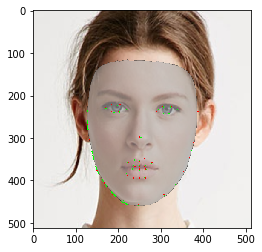

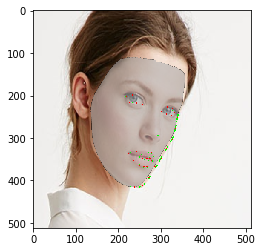

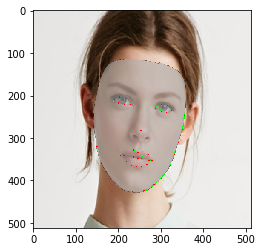

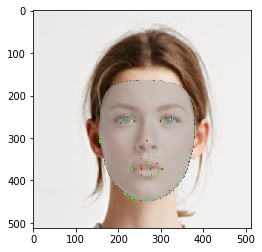

In [36]:
def pose_estimation_one_folder(folder,saveFolder,mesh, isSaveObj=False):
    
    if not os.path.exists(saveFolder):
        os.mkdir(saveFolder)
    imgs, lms = load_imgs_and_centercrop(folder)# path to your image folder

    img, lm = imgs.copy(), lms.copy()
    img_size = [img.shape[2], img.shape[1]]
    lm[...,1] = img_size[1] - lm[...,1]

    MV,affine,scale,image_points,model_ids,mesh = optimizePose_Multiply_Img(mesh,lm,ids,steps=5)

    for frameID,im in enumerate(img):

        if CameraMode == 'ortho':
            renderedImg, depth = render2(mesh,model=MV[frameID],scale=scale[frameID],resolution=im.shape[:2])
        else:
            renderedImg, depth = render(mesh,MV[frameID],scale[frameID][1,1],resolution=im.shape[:2])

        cv2.imwrite(os.path.join(saveFolder,'%02d_render.png'%frameID),im)
        
        mask = np.sum(renderedImg,axis=2)>10
        im[mask] = renderedImg[mask]*0.6 + im[mask]*0.4

        im = visLM(mesh.vertices[model_ids[frameID]],image_points[frameID],im, affine[frameID],homogeneous=True)

        plt.figure()
        plt.imshow(im[...,::-1])
        cv2.imwrite(os.path.join(saveFolder,'%02d_crop.png'%frameID),im)
        np.savetxt(os.path.join(saveFolder,'%02d.txt'%frameID),affine[frameID])
        
    if isSaveObj:
        mesh.export(os.path.join(saveFolder,'res.obj'))

folder,saveFolder = 'sample','result'
mesh.vertices = obj_base.reshape((-1,3))
pose_estimation_one_folder(folder,saveFolder,mesh, isSaveObj=False)